# Step 6: Dealing with non-stationary environments with many abrupt changes
Develop the EXP3 algorithm, which is devoted to dealing with adversarial settings. This
algorithm is also used to deal with non-stationary settings when no information about the
specific form of non-stationarity is known beforehand. Consider a simplified version of Step 5
in which the company chooses a single seed to activate in the social network at each round.
First, apply the EXP3 algorithm and the algorithms designed in Step 5 to this simplified
version of the setting. The expected result is that EXP3 performs much worse than the two
non-stationary versions of UCB1. Subsequently, consider a different non-stationary setting
with a higher non-stationarity degree. Such a degree can be modeled by having a large
number of phases that frequently change. In particular, consider 5 phases, each one
associated with a different optimal price, and these phases cyclically change with a high
frequency. In this new setting, apply EXP3, UCB1, and the two non-stationary flavors of
UBC1. The expected result is that EXP3 outperforms the non-stationary flavors of UCB1.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
from scipy.optimize import linear_sum_assignment

In [2]:
class Environment:
    def __init__(self, probabilities):
        self.probabilities = probabilities

    def round(self, pulled_arm):
        reward = np.random.binomial(1, self.probabilities[pulled_arm])
        return reward

In [3]:
class NonStationaryEnvironment(Environment):
    def __init__(self, probabilities, horizon):
        super().__init__(probabilities)
        self.t=0
        n_phases = len(self.probabilities)
        self.phase_size = horizon / n_phases

    def round(self, pulled_arm):
        current_phase = int(self.t / self.phase_size)
        p = self.probabilities[current_phase][pulled_arm]
        reward = np.random.binomial(1, p)
        self.t += 1
        return reward

In [4]:
class Learner:
    def __init__(self, n_arms) -> None:
        self.n_arms = n_arms
        self.t = 0
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = np.array([])

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, [reward])
        self.t += 1

In [5]:
class UCBLearner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.n_pulls = np.zeros(n_arms)  # count the number of times each arm has been pulled
        self.confidence = np.array([np.inf] * n_arms)

    def pull_arm(self):
        upper_confidence_bound = self.empirical_means + self.confidence
        return np.random.choice(np.where(upper_confidence_bound == upper_confidence_bound.max())[0])

    def update(self, pulled_arm, reward):
        self.t += 1
        self.n_pulls[pulled_arm] += 1
        self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm] * (
                self.n_pulls[pulled_arm] - 1) + reward) / self.n_pulls[pulled_arm]
        for a in range(self.n_arms):
            # n_samples = max(1, self.n_pulls[a])
            n_samples = self.n_pulls[a]
            self.confidence[a] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else np.inf

        self.update_observations(pulled_arm, reward)

    def expectations(self):
        return self.empirical_means


In [6]:
class SW_UCBLearner(UCBLearner):
    def __init__(self, n_arms, window_size):
        super().__init__(n_arms)
        self.window_size = window_size
        # array showing sequence of pulled arms
        self.pulled_arms = np.array([])



    # get the list of unplayed arm in the last time_window
    def get_unplayed_arms(self, pulled_arms, time_window):
      all_arms = [i for i in range(self.n_arms)]
      if len(pulled_arms) < time_window:
        return list(all_arms)
      else:
        last_time_window = pulled_arms[-time_window:]
        played_arms = set(last_time_window)
        all_arms = [i for i in range(self.n_arms)]
        unplayed_arms = set(all_arms) - played_arms
        return list(unplayed_arms)


    def pull_arm(self):
        upper_confidence_bound = self.empirical_means + self.confidence

        self.upper_confidence_bound = upper_confidence_bound

        arms = [i for i in range(self.n_arms)] # get a list of all arms
        unplayed_arms_in_window = self.get_unplayed_arms(self.pulled_arms, self.window_size)
        # if there are unplayed arms in the most recent time window, play one of them at random
        if unplayed_arms_in_window != []:
            return random.choice(unplayed_arms_in_window)
        # else play the one with highest confidence bound
        else:
            return np.random.choice(np.where(upper_confidence_bound == upper_confidence_bound.max())[0])

    def update(self, pulled_arm, reward):
        self.t += 1
        self.pulled_arms = np.append(self.pulled_arms, pulled_arm)

        for arm in range(self.n_arms):
            # count the number of times the arm has been played in the window
            n_samples = np.count_nonzero(np.array(self.pulled_arms[-self.window_size:]) == arm)
            # get the cumulative reward for the window if the arm was played at least once in the window
            cum_reward_in_window = np.sum(self.rewards_per_arm[arm][-n_samples:]) if n_samples > 0 else 0
            # empirical mean is computed
            self.empirical_means[arm] = cum_reward_in_window / n_samples if n_samples > 0 else 0
            # confidence decreasing linearly with number of samples in window
            self.confidence[arm] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else 1000

        self.update_observations(pulled_arm, reward)

    def expectations(self):
        return self.empirical_means

In [7]:
class CUSUM:
  def __init__(self, M, eps, h):
    self.M = M #Length of window considered by CD
    self.eps = eps #Epsylon
    self.h = h #Threshold
    self.t = 0
    self.reference = 0 #Reference Mean
    self.g_plus = 0
    self.g_minus = 0

  def update(self, sample):
    self.t += 1


    # If time < CD window, update reference mean with new sample and return 0
    if self.t <= self.M:
        self.reference += sample/self.M
        return 0

    # If time > CD window, compute deviations and their cumulative sum
    else:
      s_plus = (sample - self.reference) - self.eps
      s_minus = -(sample - self.reference) - self.eps
      self.g_plus = max(0, self.g_plus + s_plus)
      self.g_minus = max(0, self.g_minus+ s_minus)
      # Return 1 if cusum of deviations are over threshold h
      return self.g_plus > self.h or self.g_minus > self.h

  def reset(self):
    # Reset the parameters if a detection occurs
    self.t = 0
    self.g_minus = 0
    self.g_plus = 0

  def Rounds_After_Last_Change(self):
    return self.t

In [182]:
class CUSUMUCB(UCBLearner):
    def __init__(self, n_arms, M=1, eps=0.05, h=0.5, alpha=0.05):
        super().__init__(n_arms)
        self.change_detection = [CUSUM(M, eps, h) for _ in range(n_arms)] #List of CUSUM objects
        self.detections = [[] for _ in range(n_arms)] # List of lists of detections per arm
        self.alpha = alpha
        self.pulled_arms = np.array([])
        # Initialize tau(a) as 0 for all arms.
        self.window_sizes = [0 for i in range(n_arms)]
        


    def pull_arm(self):
      upper_confidence_bound = self.empirical_means + self.confidence
      upper_confidence_bound[np.isinf(upper_confidence_bound)] = 1e3

      if np.random.binomial(1,1-self.alpha):
        return np.random.choice(np.where(upper_confidence_bound == upper_confidence_bound.max())[0])
      else:
        return random.randint(0,self.n_arms-1)




    def update(self, pulled_arm, reward):
      self.t += 1
      self.pulled_arms = np.append(self.pulled_arms, pulled_arm)

              # Update the change detection for the arm pulled
      if self.change_detection[pulled_arm].update(reward):
        self.change_detection[pulled_arm].reset()


      for arm in range(self.n_arms):
        # update window_sizes for each arm
        self.window_sizes[arm] = self.change_detection[arm].Rounds_After_Last_Change()
        # count the number of times the arm has been played in the window
        n_samples = np.count_nonzero(np.array(self.pulled_arms[-self.window_sizes[arm]:]) == arm)
        # get the cumulative reward for the window if the arm was played at least once in the window
        cum_reward_in_window = np.sum(self.rewards_per_arm[arm][-n_samples:]) if n_samples > 0 else 0
        # empirical mean is computed
        self.empirical_means[arm] = cum_reward_in_window / n_samples if n_samples > 0 else 0
        # confidence decreasing linearly with number of samples in window
        self.confidence[arm] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else 1000


      self.update_observations(pulled_arm, reward)

    def expectations(self):
      return self.empirical_means

In [183]:
class EXP3Learner:
    def __init__(self, n_arms, gamma):
        self.n_arms = n_arms
        self.gamma = gamma
        self.weights = np.ones(n_arms)
        self.t = 0
        self.collected_rewards = np.zeros(n_arms)
        self.counts = np.zeros(n_arms)  

    def update_observations(self, pulled_arm, reward):
        self.counts[pulled_arm] += 1
        self.collected_rewards[pulled_arm] += reward
        self.t += 1

    def pull_arm(self):
        probability_distribution = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + self.gamma / self.n_arms
        return np.random.choice(self.n_arms, p=probability_distribution)

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        probability_distribution = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + self.gamma / self.n_arms
        estimated_reward = reward / probability_distribution[pulled_arm]
        self.weights[pulled_arm] = self.weights[pulled_arm] * np.exp(self.gamma * estimated_reward / self.n_arms)

    def expectations(self):
        return self.collected_rewards / (self.counts + 1e-6)
        





## Setting up problem parameters

In [114]:
node_classes = 3
product_classes = 3
products_per_class = 3

means = np.random.uniform(10, 20, (3,3))
std_dev = np.ones((3,3))
rewards_parameters = (means, std_dev)

customer_assignments = np.random.choice([0,1,2], size=30)


n_arms = 30
n_phases = 15
T = 365
n_experiments = 100



def generate_graph_probabilities(n_nodes, edge_rate):
    graph_structure = np.random.binomial(1, edge_rate, (n_nodes, n_nodes))
    graph_probabilities = np.random.uniform(0.1, 0.9, (n_nodes, n_nodes)) * graph_structure
    return graph_probabilities

n_nodes = 30
edge_rate = 0.1

prob_phase1 = prob_phase6 = prob_phase11 = np.reshape(generate_graph_probabilities(n_nodes=n_nodes,edge_rate=edge_rate),(n_nodes,n_nodes))
prob_phase2 = prob_phase7 = prob_phase12 = np.reshape(generate_graph_probabilities(n_nodes=n_nodes,edge_rate=edge_rate),(n_nodes,n_nodes))
prob_phase3 = prob_phase8 = prob_phase13 = np.reshape(generate_graph_probabilities(n_nodes=n_nodes,edge_rate=edge_rate),(n_nodes,n_nodes))
prob_phase4 = prob_phase9 = prob_phase14 = np.reshape(generate_graph_probabilities(n_nodes=n_nodes,edge_rate=edge_rate),(n_nodes,n_nodes))
prob_phase5 = prob_phase10 = prob_phase15 = np.reshape(generate_graph_probabilities(n_nodes=n_nodes,edge_rate=edge_rate),(n_nodes,n_nodes))


p = np.stack((prob_phase1, prob_phase2, prob_phase3, prob_phase4, prob_phase5,
             prob_phase6, prob_phase7, prob_phase8, prob_phase9, prob_phase10, 
             prob_phase11, prob_phase12, prob_phase13, prob_phase14, prob_phase15), axis=0)
 

K = np.array([p[:, i] for i in range(p.shape[1])])








### Estimating non-stationary probabilities with Sliding Window UCB

In [115]:
window_size = int(T/10)

def SW_Generate_Probability_Estimates(p, n_arms=n_arms, n_phases=n_phases, T=T, window_size=window_size, n_experiments=10):
    phases_len = int(T / n_phases)
    swucb_rewards_per_experiment = []

    experimentS_means_at_each_round = np.empty((n_experiments, T, n_arms))

    for e in tqdm(range(0, n_experiments)):
        # Initialize environment
        swucb_env = NonStationaryEnvironment(p, T)
        # Initialize learner
        swucb_learner = SW_UCBLearner(n_arms=n_arms, window_size=window_size)

        for t in range(0, T):
            # SW-UCB Learner
            pulled_arm = swucb_learner.pull_arm()
            reward = swucb_env.round(pulled_arm)
            swucb_learner.update(pulled_arm, reward)

            # At each round memorize a copy of the means of each arm
            expected_rew = swucb_learner.expectations()
            experimentS_means_at_each_round[e, t] = expected_rew.copy()

    return experimentS_means_at_each_round

In [116]:
SW_rounds_probabilities_for_each_arm = []

for index in range(len(K)):
    print("Learning for row:",index)
    estimates = SW_Generate_Probability_Estimates(K[index])
    SW_rounds_probabilities_for_each_arm.append(estimates)

SW_rounds_probabilities_for_each_arm = np.mean(SW_rounds_probabilities_for_each_arm, axis=1)

Learning for row: 0


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.08it/s]


Learning for row: 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.91it/s]


Learning for row: 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.70it/s]


Learning for row: 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.05it/s]


Learning for row: 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.07it/s]


Learning for row: 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.96it/s]


Learning for row: 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.50it/s]


Learning for row: 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.08it/s]


Learning for row: 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.92it/s]


Learning for row: 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.98it/s]


Learning for row: 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.77it/s]


Learning for row: 11


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.19it/s]


Learning for row: 12


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.03it/s]


Learning for row: 13


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.22it/s]


Learning for row: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.13it/s]


Learning for row: 15


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.13it/s]


Learning for row: 16


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.70it/s]


Learning for row: 17


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]


Learning for row: 18


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.60it/s]


Learning for row: 19


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.66it/s]


Learning for row: 20


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.58it/s]


Learning for row: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.76it/s]


Learning for row: 22


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.74it/s]


Learning for row: 23


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.28it/s]


Learning for row: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.65it/s]


Learning for row: 25


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.33it/s]


Learning for row: 26


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.06it/s]


Learning for row: 27


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.07it/s]


Learning for row: 28


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.04it/s]


Learning for row: 29


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.20it/s]


### Estimating non-stationary probabilities with Change Detection CUSUM UCB

In [197]:
def CUSUM_Generate_Probability_Estimates(p, n_arms=n_arms, n_phases=n_phases, T=T, n_experiments=4):
    phases_len = int(T / n_phases)
    cusum_rewards_per_experiment = []

    experimentS_means_at_each_round = np.empty((n_experiments, T, n_arms))

    for e in tqdm(range(0, n_experiments)):
        # Initialize environment
        cusum_env = NonStationaryEnvironment(probabilities=p, horizon=T)
        # Initialize learner
        cusum_learner = CUSUMUCB(n_arms=n_arms, M=1, eps=0.05, h=0.4, alpha=0.3)

        for t in range(0, T):
            pulled_arm = cusum_learner.pull_arm()
            reward = cusum_env.round(pulled_arm)
            cusum_learner.update(pulled_arm, reward)

            # At each round memorize a copy of the means of each arm
            expected_rew = cusum_learner.expectations()
            experimentS_means_at_each_round[e, t] = expected_rew.copy()

    return experimentS_means_at_each_round

In [198]:
CUSUM_rounds_probabilities_for_each_arm = []

for index in range(len(K)):
    print("Learning for row:",index)
    estimates = CUSUM_Generate_Probability_Estimates(K[index])
    CUSUM_rounds_probabilities_for_each_arm.append(estimates)

CUSUM_rounds_probabilities_for_each_arm = np.mean(CUSUM_rounds_probabilities_for_each_arm, axis=1)

Learning for row: 0


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


Learning for row: 1


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.58it/s]


Learning for row: 2


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.07it/s]


Learning for row: 3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.74it/s]


Learning for row: 4


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.44it/s]


Learning for row: 5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.05it/s]


Learning for row: 6


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.62it/s]


Learning for row: 7


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.08it/s]


Learning for row: 8


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


Learning for row: 9


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.83it/s]


Learning for row: 10


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.55it/s]


Learning for row: 11


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.04it/s]


Learning for row: 12


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.19it/s]


Learning for row: 13


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.40it/s]


Learning for row: 14


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.17it/s]


Learning for row: 15


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.88it/s]


Learning for row: 16


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Learning for row: 17


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


Learning for row: 18


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.91it/s]


Learning for row: 19


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.46it/s]


Learning for row: 20


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.71it/s]


Learning for row: 21


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


Learning for row: 22


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.69it/s]


Learning for row: 23


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.98it/s]


Learning for row: 24


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.37it/s]


Learning for row: 25


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.80it/s]


Learning for row: 26


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.09it/s]


Learning for row: 27


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81it/s]


Learning for row: 28


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.90it/s]


Learning for row: 29


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.93it/s]


### Estimating non-stationary probabilities with EXP3

In [169]:
gamma = 0.15 # Parameter for the EXP3 algorithm

def EXP3_Generate_Probability_Estimates(p, n_arms=n_arms, n_phases=n_phases, T=T, n_experiments=10):
    phases_len = int(T / n_phases)
    exp3_rewards_per_experiment = []

    experimentS_means_at_each_round = np.empty((n_experiments, T, n_arms))

    for e in tqdm(range(0, n_experiments)):
        # Initialize environment
        exp3_env = NonStationaryEnvironment(probabilities=p, horizon=T)
        # Initialize learner
        exp3_learner = EXP3Learner(n_arms=n_arms, gamma=gamma)

        for t in range(0, T):
            # SW-UCB Learner
            pulled_arm = exp3_learner.pull_arm()
            reward = exp3_env.round(pulled_arm)
            exp3_learner.update(pulled_arm, reward)

            # At each round memorize a copy of the means of each arm
            expected_rew = exp3_learner.expectations()
            experimentS_means_at_each_round[e, t] = expected_rew.copy()

    return experimentS_means_at_each_round

In [170]:
EXP3_rounds_probabilities_for_each_arm = []

for index in range(len(K)):
    print("Learning for row:",index)
    estimates = EXP3_Generate_Probability_Estimates(K[index])
    EXP3_rounds_probabilities_for_each_arm.append(estimates)

EXP3_rounds_probabilities_for_each_arm = np.mean(EXP3_rounds_probabilities_for_each_arm, axis=1)

Learning for row: 0


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.40it/s]


Learning for row: 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.53it/s]


Learning for row: 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.36it/s]


Learning for row: 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.78it/s]


Learning for row: 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.43it/s]


Learning for row: 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.52it/s]


Learning for row: 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.65it/s]


Learning for row: 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.22it/s]


Learning for row: 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.21it/s]


Learning for row: 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.11it/s]


Learning for row: 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.68it/s]


Learning for row: 11


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.51it/s]


Learning for row: 12


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.54it/s]


Learning for row: 13


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.11it/s]


Learning for row: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.50it/s]


Learning for row: 15


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 23.36it/s]


Learning for row: 16


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.03it/s]


Learning for row: 17


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.90it/s]


Learning for row: 18


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.44it/s]


Learning for row: 19


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.50it/s]


Learning for row: 20


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.88it/s]


Learning for row: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.37it/s]


Learning for row: 22


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 23.04it/s]


Learning for row: 23


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.22it/s]


Learning for row: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.55it/s]


Learning for row: 25


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.56it/s]


Learning for row: 26


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.38it/s]


Learning for row: 27


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.39it/s]


Learning for row: 28


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.45it/s]


Learning for row: 29


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.42it/s]


In [171]:
def Reshape(LIST):
  # Convert the lists into a NumPy array
  array_of_lists = np.array(LIST)
  # Transpose the array to swap the axes
  transposed_array = array_of_lists.T
  # Split the transposed array into separate arrays along axis=1
  return np.split(transposed_array, transposed_array.shape[1], axis=1)


In [199]:
estimated_tables_SW = Reshape(SW_rounds_probabilities_for_each_arm)
estimated_tables_CUSUM = Reshape(CUSUM_rounds_probabilities_for_each_arm)
estimated_tables_EXP3 = Reshape(EXP3_rounds_probabilities_for_each_arm)


In [200]:
T = 365
phases_len = int(T / n_phases)
phases_array = np.empty((0, n_nodes, n_nodes))

for table in range(len(p)):
    repeated_values = np.repeat(p[table][np.newaxis, :, :], phases_len+1, axis=0)
    phases_array = np.vstack((phases_array, repeated_values))

phases_array = phases_array[:T, :, :]

In [201]:
SW_reward = [np.sum(i) for i in estimated_tables_SW]
CUSUM_reward = [np.sum(i) for i in estimated_tables_CUSUM]
EXP3_reward = [np.sum(i) for i in estimated_tables_EXP3]
Clairv = [np.sum(i) for i in phases_array]


### Plotting Instantaneous Reward of Edge Activation Probability Estimation

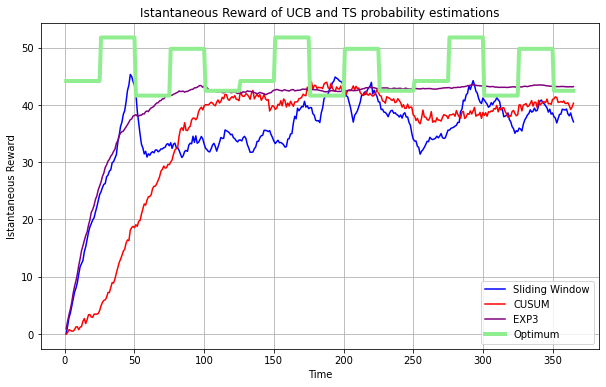

In [202]:
time_periods = range(1, 366)

plt.figure(figsize=(10, 6))

plt.plot(time_periods, SW_reward, color='blue', linestyle='-', label='Sliding Window')
plt.plot(time_periods, CUSUM_reward, color='red', linestyle='-', label='CUSUM')
plt.plot(time_periods, EXP3_reward, color='purple', linestyle='-', label='EXP3')
plt.plot(time_periods, Clairv, color='lightgreen', linestyle='-', label='Optimum', linewidth=4)


plt.xlabel('Time')
plt.ylabel('Istantaneous Reward')
plt.title('Istantaneous Reward of UCB and TS probability estimations')

plt.legend()
plt.grid()

plt.show()

In [203]:
estimated_tables_SW = np.array(estimated_tables_SW)
estimated_tables_CUSUM = np.array(estimated_tables_CUSUM)
estimated_tables_EXP3 = np.array(estimated_tables_EXP3)

In [204]:
original_shape = estimated_tables_SW.shape
estimated_tables_SW = estimated_tables_SW.reshape(original_shape[0], original_shape[1], original_shape[3])
estimated_tables_CUSUM = estimated_tables_CUSUM.reshape(original_shape[0], original_shape[1], original_shape[3])
estimated_tables_EXP3 = estimated_tables_EXP3.reshape(original_shape[0], original_shape[1], original_shape[3])


### Plotting Regrets of Edge Activation Probability Estimation

In [205]:
SW_regret = np.sum((phases_array - estimated_tables_SW),axis=(1,2))
CUSUM_regret = np.sum((phases_array - estimated_tables_CUSUM),axis=(1,2))
EXP3_regret = np.sum((phases_array - estimated_tables_EXP3),axis=(1,2))
SW_cumulative_regret = np.cumsum(SW_regret)
CUSUM_cumulative_regret = np.cumsum(CUSUM_regret)
EXP3_cumulative_regret = np.cumsum(EXP3_regret)


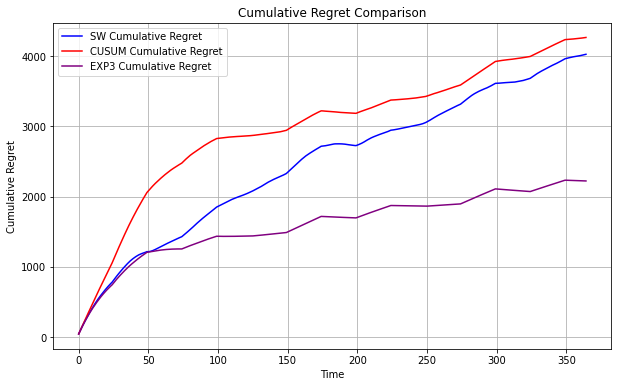

In [206]:
plt.figure(figsize=(10, 6))
plt.plot(SW_cumulative_regret, label='SW Cumulative Regret', color="blue")
plt.plot(CUSUM_cumulative_regret, label='CUSUM Cumulative Regret', color = "red")
plt.plot(EXP3_cumulative_regret, label='EXP3 Cumulative Regret', color = "purple")

plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret Comparison')
plt.legend()
plt.grid()
plt.show()

In [207]:
def hungarian_algorithm(matrix):
    m = matrix.copy()
    n_rows, n_cols = m.shape
    max_val = np.max(m)

    if n_rows > n_cols:
        m = np.pad(m, ((0, 0), (0, n_rows - n_cols)), mode='constant', constant_values=max_val)
    elif n_cols > n_rows:
        m = np.pad(m, ((0, n_cols - n_rows), (0, 0)), mode='constant', constant_values=max_val)

    assigned_rows, assigned_cols = linear_sum_assignment(m)

    assignment = np.zeros_like(m, dtype=int)
    assignment[assigned_rows, assigned_cols] = 1

    return assignment[:n_rows, :n_cols] * matrix, assignment[:n_rows, :n_cols]

def generate_reward(mean, std_dev):
    return lambda: np.random.normal(mean, std_dev)



def get_reward(node_class, product_class, rewards_parameters):
    return np.random.normal(rewards_parameters[0][node_class, product_class], rewards_parameters[1][node_class, product_class])

def clairvoyant(graph_probabilities, true_prob, customer_assignments, rewards_parameters, real_reward_parameters, n_exp, seeds=None):
    hungarian_matrix = hungarian_algorithm(rewards_parameters[0])[1]

    reward_per_experiment = [[] for i in range(n_exp)]

    if seeds == None:
        opt_seeds = greedy_algorithm(graph_probabilities, 1, 100, 100)
    else:
        opt_seeds = seeds

    for e in tqdm(range(n_exp)):

        history = simulate_episode(true_prob, opt_seeds, 10)[0]
        activation_flow = np.concatenate([np.where(row == 1)[0] for row in history]).tolist()
        class_activation_flow = customer_assignments[activation_flow]
        exp_reward = 0

        units = [3, 3, 3]

        while units > [0, 0, 0]:

            for customer in class_activation_flow:

                # Find mean of matching reward
                nonzero_index = np.nonzero(hungarian_matrix[customer])
                product_class = int(nonzero_index[0][0])

                if units[product_class] != 0:
                    reward = get_reward(customer, product_class, real_reward_parameters)
                    units[product_class] = units[product_class] - 1

                else:
                    instock_units = [index for index, value in enumerate(units) if value != 0]
                    if instock_units:  # Check if instock_units is not empty before choosing
                        product_class = random.choice(instock_units)
                        reward = get_reward(customer, product_class, real_reward_parameters)
                        units[product_class] -= 1
                    else:
                        # Handle the case when units is empty (no available units)
                        reward = 0

                exp_reward = exp_reward + reward

            reward_per_experiment[e] = exp_reward

    return np.mean(reward_per_experiment), np.std(reward_per_experiment)


import numpy as np
from tqdm import tqdm

def simulate_episode(init_prob_matrix, seeds:list, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    #set up seeds
    active_nodes=np.zeros(n_nodes)

    for seed in seeds:
        active_nodes[seed]=1

    history=np.array([active_nodes])

    newly_active_nodes=active_nodes

    t=0

    while (t<max_steps and np.sum(newly_active_nodes)>0):
        #retrieve probability of edge activations
        p = (prob_matrix.T*active_nodes).T
        activated_edges=p>np.random.rand(p.shape[0], p.shape[1])
        #remove activated edges
        prob_matrix=prob_matrix*((p!=0)==activated_edges)
        #update active nodes
        newly_active_nodes=(np.sum(activated_edges, axis=0)>0)*(1-active_nodes)
        #print(newly_active_nodes)
        active_nodes=np.array(active_nodes+newly_active_nodes)
        #print(active_nodes)
        history=np.concatenate((history, [newly_active_nodes]), axis=0)
        t+=1
    return history, active_nodes

def test_seed(seeds, prob_matrix, k, max_steps):
    reward = 0
    for i in range(k):
        history, active_nodes=simulate_episode(prob_matrix, seeds, max_steps)
        reward+=np.sum(active_nodes)
    return reward/k

def greedy_algorithm(init_prob_matrix, budget, k, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    seeds=[]
    for j in range(budget):
        rewards=np.zeros(n_nodes)

        for i in tqdm(range(n_nodes)):
            if i not in seeds:
                rewards[i]=test_seed([i]+seeds, prob_matrix, k, max_steps)
        seeds.append(np.argmax(rewards))

    return seeds

## Computing overall reward using probability estimates

In [208]:
n_exp = 4

SW_mean_rewards_per_round = []
SW_std_dev_rewards_per_round = []
for table in tqdm(range(len(estimated_tables_SW))):
    true_p = phases_array[table]
    table = np.reshape(estimated_tables_SW[table],(30,30))
    clairvoyant_output = clairvoyant(table, true_p, customer_assignments, rewards_parameters, rewards_parameters, n_exp)
    SW_mean_rewards_per_round.append(clairvoyant_output[0])
    SW_std_dev_rewards_per_round.append(clairvoyant_output[1])

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.74it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 114.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 108.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.22it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.88it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.44it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.98it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.36it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 25.39it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.42it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 39.24it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.01it/s]

 53%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.24it/s]

 67%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.09it/s]

 47%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.27it/s]

 17%|█████████████▊             

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.01it/s]

 33%|███████████████████████████▎                                                      | 10/30 [00:00<00:00, 36.26it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.79it/s]

 30%|████████████████████████▉                                                          | 9/30 [00:00<00:00, 30.67it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.35it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 37.04it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.64it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.84it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.57it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 27.80it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.86it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.88it/s]

 38%|██████████████████████████████▋                                                 | 140/365 [01:45<03:11,  1.18it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.46it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.90it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.79it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.08it/s]

 50%|█████████████████████████████████████████                                         | 15/30 [00:00<00:00, 30.40it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.69it/s]

 53%|███████████████████████████████████████████▋                                      | 16/30 [00:00<00:00, 30.04it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 800.06it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.70it/s]

 53%|███████████████████████████████████████████▋                                      | 16/30 [00:00<00:00, 32.05it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.97it/s]

 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:00<00:00, 25.83it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.52it/s]

 43%|███████████████████████████████████▌                                              | 13/30 [00:00<00:00, 29.41it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.59it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 37.68it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.66it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 31.71it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.76it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 25.79it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.53it/s]

 50%|█████████████████████████████████████████                                         | 15/30 [00:00<00:00, 27.34it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.83it/s]

 10%|████████▎                                                                          | 3/30 [00:00<00:00, 27.52it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.34it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 39.59it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.44it/s]

 50%|█████████████████████████████████████████                                         | 15/30 [00:00<00:00, 28.70it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.76it/s]

 67%|█████████████████████████████████████████████████████▉                          | 246/365 [03:38<01:58,  1.00it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.47it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.39it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.92it/s]

 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:00<00:00, 39.31it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.01it/s]

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:00<00:00, 35.21it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.76it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 35.60it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.85it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [00:01<00:00, 24.98it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.47it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 25.64it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.01it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 32.14it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [00:00<00:00, 28.72it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.99it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.92it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:00<00:00, 37.57it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.14it/s]

 30%|████████████████████████▉                                                          | 9/30 [00:00<00:00, 28.51it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.57it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.16it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 30.54it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.12it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 42.37it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.57it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 31.24it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [05:29<00:00,  1.11it/s]


In [209]:
CUSUM_mean_rewards_per_round = []
CUSUM_std_dev_rewards_per_round = []
for table in tqdm(range(len(estimated_tables_CUSUM))):
    true_p = phases_array[table]
    table = np.reshape(estimated_tables_CUSUM[table],(30,30))
    clairvoyant_output = clairvoyant(table, true_p, customer_assignments, rewards_parameters, rewards_parameters, n_exp)
    CUSUM_mean_rewards_per_round.append(clairvoyant_output[0])
    CUSUM_std_dev_rewards_per_round.append(clairvoyant_output[1])


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.57it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 115.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.28it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 120.95it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.62it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.94it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.14it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.27it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 120.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.75it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 114.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.63it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.22it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.51it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.99it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.76it/s]

 47%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.68it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 32.50it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.86it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.97it/s]

 26%|█████████████████████▎                                                           | 96/365 [00:51<04:14,  1.06it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 30.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.39it/s]

 30%|████████████████████████▉                                                          | 9/30 [00:00<00:00, 32.14it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.98it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 28.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.21it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.54it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 33.33it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.05it/s]

 47%|██████████████████████████████████████▎                                           | 14/30 [00:00<00:00, 31.98it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.95it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 27.27it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.24it/s]

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 27.13it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.64it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.29it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 38.46it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.27it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.39it/s]

 53%|███████████████████████████████████████████▋                                      | 16/30 [00:00<00:00, 34.14it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.23it/s]

 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:00<00:00, 27.86it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.19it/s]

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:00<00:00, 26.61it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.20it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 30.89it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.87it/s]

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:00<00:00, 24.76it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1333.22it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.85it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.96it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 29.98it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.28it/s]

 30%|████████████████████████▉                                                          | 9/30 [00:00<00:00, 27.64it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.56it/s]

 53%|███████████████████████████████████████████▋                                      | 16/30 [00:00<00:00, 28.84it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.03it/s]

 43%|███████████████████████████████████▌                                              | 13/30 [00:00<00:00, 26.33it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.86it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:00<00:00, 29.16it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.54it/s]

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:00<00:00, 24.98it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.88it/s]

 67%|█████████████████████████████████████████████████████▋                          | 245/365 [03:28<01:58,  1.01it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.77it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 46.18it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.92it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 29.86it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.31it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 43.10it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.56it/s]

 74%|███████████████████████████████████████████████████████████▍                    | 271/365 [03:53<01:26,  1.09it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.75it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 33.81it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 499.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.14it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 32.15it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.09it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.58it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 34.61it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.11it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 30.86it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.91it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.70it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 33.74it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.11it/s]

 33%|███████████████████████████▎                                                      | 10/30 [00:00<00:00, 40.51it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.29it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.71it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 400.05it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.93it/s]

 95%|████████████████████████████████████████████████████████████████████████████▎   | 348/365 [05:09<00:17,  1.02s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 499.99it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.84it/s]

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 360/365 [05:22<00:05,  1.08s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [05:27<00:00,  1.11it/s]


In [210]:
EXP3_mean_rewards_per_round = []
EXP3_std_dev_rewards_per_round = []
for table in tqdm(range(len(estimated_tables_EXP3))):
    true_p = phases_array[table]
    table = np.reshape(estimated_tables_EXP3[table],(30,30))
    clairvoyant_output = clairvoyant(table, true_p, customer_assignments, rewards_parameters, rewards_parameters, n_exp)
    EXP3_mean_rewards_per_round.append(clairvoyant_output[0])
    EXP3_std_dev_rewards_per_round.append(clairvoyant_output[1])


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.91it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.95it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.74it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.55it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.15it/s]

 50%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.87it/s]

 10%|████████▍                  

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.60it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.43it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 32.24it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 799.45it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.47it/s]

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 28.88it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.29it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.41it/s]

 33%|███████████████████████████▎                                                      | 10/30 [00:00<00:00, 26.26it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.64it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 27.20it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.61it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 36.52it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.36it/s]

 37%|██████████████████████████████                                                    | 11/30 [00:00<00:00, 23.42it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.06it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 30.27it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.63it/s]

 29%|███████████████████████▍                                                        | 107/365 [01:32<05:02,  1.17s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.87it/s]

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:01<00:00, 22.68it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.88it/s]

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:00<00:00, 29.86it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.42it/s]

 33%|███████████████████████████▎                                                      | 10/30 [00:00<00:00, 29.64it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.61it/s]

 20%|████████████████▌                                                                  | 6/30 [00:00<00:01, 22.70it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.26it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 36.29it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.91it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 28.43it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.37it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 27.62it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.36it/s]

 43%|███████████████████████████████████▌                                              | 13/30 [00:00<00:00, 25.69it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.52it/s]

 43%|███████████████████████████████████▌                                              | 13/30 [00:00<00:00, 29.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.63it/s]

 37%|██████████████████████████████                                                    | 11/30 [00:00<00:00, 27.72it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.22it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 26.15it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.55it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:01, 25.90it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.15it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.12it/s]

 30%|████████████████████████▉                                                          | 9/30 [00:00<00:00, 24.70it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.74it/s]

 30%|████████████████████████▉                                                          | 9/30 [00:00<00:00, 24.11it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.30it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 960.45it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.34it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:00<00:00, 23.36it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.70it/s]

 37%|██████████████████████████████                                                    | 11/30 [00:00<00:00, 27.80it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.74it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 39.99it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.99it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.93it/s]

 67%|█████████████████████████████████████████████████████▎                          | 243/365 [04:05<02:16,  1.12s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.67it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.53it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 23.19it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.45it/s]

 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:00<00:00, 23.69it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.06it/s]

 73%|██████████████████████████████████████████████████████████▎                     | 266/365 [04:32<02:04,  1.25s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.89it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 29.51it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.15it/s]

 76%|████████████████████████████████████████████████████████████▋                   | 277/365 [04:46<01:46,  1.21s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.89it/s]

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:01<00:00, 22.14it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.90it/s]

 30%|████████████████████████▉                                                          | 9/30 [00:00<00:00, 27.21it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.25it/s]

 81%|████████████████████████████████████████████████████████████████▍               | 294/365 [05:07<01:27,  1.23s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.58it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.52it/s]

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 23.68it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.46it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:01, 16.39it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.02it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.91it/s]

 37%|██████████████████████████████                                                    | 11/30 [00:00<00:00, 22.83it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.59it/s]

 90%|███████████████████████████████████████████████████████████████████████▉        | 328/365 [05:48<00:43,  1.18s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.75it/s]



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.87it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 24.65it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.29it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 27.68it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.40it/s]

 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:00<00:00, 26.43it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.24it/s]

 50%|█████████████████████████████████████████                                         | 15/30 [00:00<00:00, 27.29it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.48it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 21.51it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.11it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [06:31<00:00,  1.07s/it]


In [215]:
optimum_means = []
for table in tqdm(p):
    a = []
    for i in range(30):
        z = clairvoyant(table, table, customer_assignments, rewards_parameters, rewards_parameters, n_exp=10)[0]
        a.append(z)
    clairvoyant_output = max(a)
        
    for i in range(int(365 / 15)+1):
        optimum_means.append(clairvoyant_output)


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.02it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.69it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.73it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.65it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.79it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 20.17it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 992.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.60it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 18.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.61it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.00it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.26it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.53it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 18.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.79it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 742.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.41it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.51it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1222.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 638.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.37it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1216.97it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.91it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 17.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.10it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.74it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 20.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 595.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 438.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.65it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 18.73it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.65it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 20.42it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 319.71it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 319.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.70it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 744.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 319.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.00it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.23it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.72it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 404.48it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.26it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.80it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.27it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1251.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.58it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.63it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.32it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.71it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.65it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.74it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.97it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.71it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.74it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.66it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.08it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.66it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.66it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.25it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.74it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 400.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.41it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 638.90it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.66it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.03it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.38it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.97it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.11it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.31it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.32it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.02it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.60it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.68it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.73it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.73it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.41it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.47it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.41it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.79it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.32it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.73it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.41it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 4899.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 20.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.97it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.70it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.73it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 20.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.87it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.51it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.32it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.75it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.84it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.44it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.24it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 984.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.75it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.66it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.89it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.38it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.66it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.02it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.85it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.65it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.60it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.94it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.94it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 530.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1235.33it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.79it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.72it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.62it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.70it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 20.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.89it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 319.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.72it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.62it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.55it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.37it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.26it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.84it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.51it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.65it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 638.57it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.97it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.57it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 641.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 20.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.81it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.68it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.10it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.85it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.43it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.09it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.69it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.79it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.41it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 638.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.32it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.17it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.28it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 20.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 695.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.45it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.71it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 20.16it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 615.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1076.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.28it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.79it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.51it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 20.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 20.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.68it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.82it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.14it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 638.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.58it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 20.16it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.09it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.46it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 20.72it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.48it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.00it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.34it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.65it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.96it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.31it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.60it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.74it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.72it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 521.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.27it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.28it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.45it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.67it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.66it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.66it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.84it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.70it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.35it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.34it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.73it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.58it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.89it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.75it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.32it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.53it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.20it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.75it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.58it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.73it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.10it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 492.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

100%|███████████████████████████

In [217]:
optimum_means = optimum_means[:T]

### Plotting Overall Instantaneous Rewards 

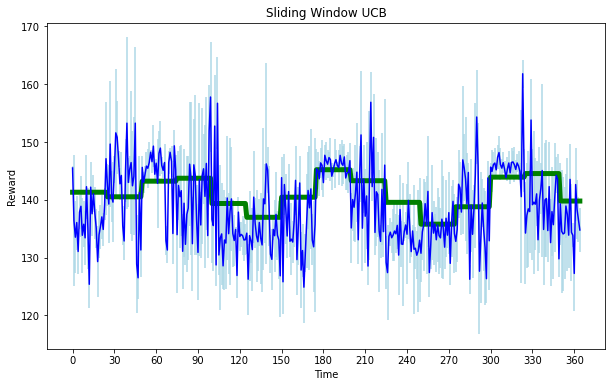

<Figure size 720x432 with 0 Axes>

In [226]:

plt.figure(figsize=(10, 6)) 

time_periods = range(len(SW_mean_rewards_per_round))

for t in time_periods:
    mean = SW_mean_rewards_per_round[t]
    std_dev = SW_std_dev_rewards_per_round[t]
    plt.vlines(t, mean - std_dev, mean + std_dev, color='lightblue')


plt.plot(time_periods, optimum_means, color='green', linestyle='-', linewidth=5)
plt.plot(time_periods, SW_mean_rewards_per_round, color='blue', linestyle='-')




plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Sliding Window UCB')

plt.xticks(time_periods[::30])

plt.figure(figsize=(10, 6))

plt.show()

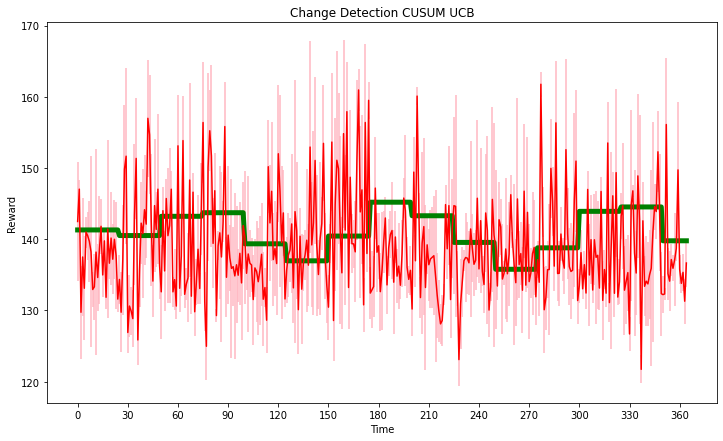

<Figure size 720x432 with 0 Axes>

In [227]:
plt.figure(figsize=(12, 7))


time_periods = range(len(CUSUM_mean_rewards_per_round))

for t in time_periods:
    mean = CUSUM_mean_rewards_per_round[t]
    std_dev = CUSUM_std_dev_rewards_per_round[t]
    plt.vlines(t, mean - std_dev, mean + std_dev, color='lightpink')


plt.plot(time_periods, optimum_means, color='green', linestyle='-', linewidth=5)
plt.plot(time_periods, CUSUM_mean_rewards_per_round, color='red', linestyle='-')




plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Change Detection CUSUM UCB')

plt.xticks(time_periods[::30])

plt.figure(figsize=(10, 6))

plt.show()

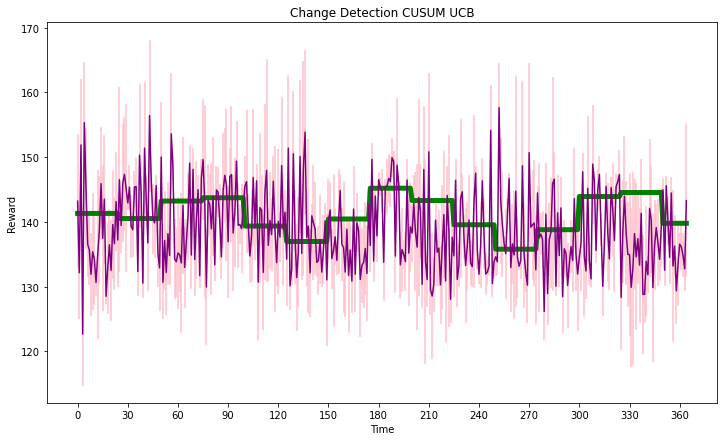

<Figure size 720x432 with 0 Axes>

In [225]:
plt.figure(figsize=(12, 7))


time_periods = range(len(EXP3_mean_rewards_per_round))

for t in time_periods:
    mean = EXP3_mean_rewards_per_round[t]
    std_dev = EXP3_std_dev_rewards_per_round[t]
    plt.vlines(t, mean - std_dev, mean + std_dev, color='pink')


plt.plot(time_periods, optimum_means, color='green', linestyle='-', linewidth=5)
plt.plot(time_periods, EXP3_mean_rewards_per_round, color='purple', linestyle='-')




plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Change Detection CUSUM UCB')

plt.xticks(time_periods[::30])

plt.figure(figsize=(10, 6))

plt.show()

### Plotting Overall Cumulative Regret

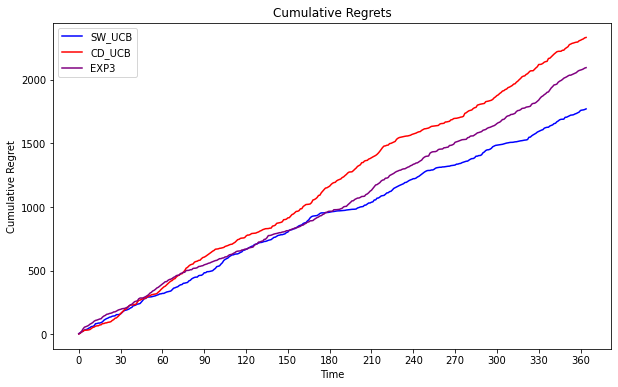

<Figure size 720x432 with 0 Axes>

In [228]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))  


SW_cumulative_regret = [sum([abs(x - y) for x, y in zip(optimum_means[:t+1], SW_mean_rewards_per_round[:t+1])]) for t in time_periods]
CD_cumulative_regret = [sum([abs(x - y) for x, y in zip(optimum_means[:t+1], CUSUM_mean_rewards_per_round[:t+1])]) for t in time_periods]
EXP3_cumulative_regret = [sum([abs(x - y) for x, y in zip(optimum_means[:t+1], EXP3_mean_rewards_per_round[:t+1])]) for t in time_periods]

plt.plot(time_periods, SW_cumulative_regret, color='blue', linestyle='-', label="SW_UCB")
plt.plot(time_periods, CD_cumulative_regret, color="red", linestyle="-", label="CD_UCB")
plt.plot(time_periods, EXP3_cumulative_regret, color="purple", linestyle="-", label="EXP3")

plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regrets')

plt.xticks(time_periods[::30])
plt.legend()

plt.figure(figsize=(10, 6))
plt.show()
